# 필요한 모듈 import

In [1]:
import requests
from bs4 import BeautifulSoup

from openpyxl import Workbook

from konlpy.tag import Okt
from collections import Counter

import pytagcloud

import pandas as pd
import matplotlib.pyplot as plt

import json
import re

import os
import holidays

import random
from IPython.display import Image

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 웹 스크래핑

In [2]:
# '년월별_요즘화제.xlsx' 엑셀 파일이 없을 때 코드 실행
FILE_PATH = '년월별_요즘화제.xlsx'

if os.path.exists(FILE_PATH):
    print(f"The code below will not be executed because the file {FILE_PATH} already exists.")    
else:
    # 빈 엑셀 파일 생성
    wb = Workbook(write_only=True)
    
    # https://ko.wikipedia.org/wiki/%ED%8F%AC%ED%84%B8:%EC%9A%94%EC%A6%98_%ED%99%94%EC%A0%9C 2016년부터 2023년까지 '요즘화제' 데이터 스크래핑
    for year in range(2016, 2024):
        # 년별로 워크시트 생성
        ws = wb.create_sheet(f'{year}년_월별_요즘화제') 
        
        # 워크시트 헤더 추가
        ws.append(['날짜', '내용'])

        # 1월에서 12월까지
        for month in range(1, 13):
            # try except 구문으로 에러 이유 쉽게 잡도록 함.
            try:
                # 페이지 로드
                url = f'https://ko.wikipedia.org/wiki/{year}%EB%85%84_{month}%EC%9B%94'
                response = requests.get(url)
                soup = BeautifulSoup(response.text, 'html.parser')

                # 2016년 1, 2월 데이터는 html형식이 다르기 때문에 나머지 데이터와 다른 방식으로 스크래핑한다.
                if year == 2016 and month in [1,2]:
                    
                    # 워크시트 각 행에 넣을 data 리스트 초기화
                    data = []
    
                    # 날짜 데이터가 text형태로 담겨있는 span태그의 부모태그 h2 태그를 먼저 찾는다. (반환타입 리스트)
                    h2_tags = soup.select('h2')
    
                    # 각 h2 태그를 순회
                    for h2 in h2_tags:
                        # h2 태그의 자식 태그 span.mw-headline 태그를 찾기 (날짜 데이터가 텍스트로 담겨있음)
                        headline = h2.select_one('span.mw-headline')
    
                        if headline:
                            # 날짜 텍스트 추출
                            date_text = headline.get_text()

                            # 날짜에 해당하는 뉴스 데이터를 전부 가져오기 위해 h2태그의 형제 태그를 찾는다. (뉴스 텍스트는 ul 태그의 하위 태그의 li 태그에 있다.)
                            next_sibling = h2.find_next_sibling()

                            # 뉴스 데이터가 담긴 li 태그들을 저장할 리스트
                            li_tags = []
                            
                            # next_sibling이 없거나 (페이지의 마지막 뉴스에 도달한 경우) h2태그가 나오면 (날짜에 해당하는 뉴스가 더 이상 없는 경우) 반복문을 빠져나옴. 
                            while next_sibling and next_sibling.name != 'h2':
                                
                                # 형제 태그 중 스크래핑과 관련없는 dl 태그도 존재하기 때문에 if문으로 체킹한다.
                                if next_sibling.name == 'ul':
                                    # ul 태그 내의 모든 li 태그를 찾기
                                    li_tags.extend(next_sibling.find_all('li'))
                                # next_sibling 갱신.
                                next_sibling = next_sibling.find_next_sibling()
                            
                            # li 태그들의 텍스트를 저장할 리스트 초기화
                            li_text_list = []    

                            # 앞에서 찾은 모든 li 태그들을 순회하면서 텍스트를 추출한다.
                            for li in li_tags:
                                li_text = li.get_text()
                                li_text_list.append(li_text)
                                li_text_cleaned = ' '.join(li_text_list)
                            
                            row = [date_text, li_text_cleaned]
    
                            data.append(row)
                            
                    # 웹에 날짜가 거꾸로 돼 있어서 row 데이터를 역순으로 엑셀에 추가
                    for row in reversed(data):
                        ws.append(row)
                        #print("succeed")
                
                # 2016년 3월 부터는 html형식이 달라지므로 아래와 같이 코딩한다.
                else:   
                    # td.description 안에 li 태그에 뉴스 데이터가 있다.
                    td_tags = soup.select('td.description')
                    
                    # 2016년 1월, 2월에는 뉴스가 있는 날만 데이터가 있었지만 그 이후는 뉴스가 없더라도 날짜는 적혀있다.
                    # td.description 안에 text가 없더라도 td.description은 모든 일자에 존재한다.
                    # 결국, td.description의 인덱스와 span.summary (날짜 데이터가 담긴 태그)의 인덱스는 무조건 동일하다. 이를 이용해 날짜와 내용을 매칭한다.
                    for date_i, td_tag in enumerate(td_tags):
    
                        # 날짜 데이터는 span.summary에 있다.
                        date = soup.select('span.summary')[date_i].get_text()
                        date_split = date.split(' ')
                        # span.summary의 모든 text를 가져오다보다 날짜 데이터 중 필요없는 것들이 같이 추출 되어 필요한 것만 추출.
                        date_cleaned = f'{date_split[3]} {date_split[4]} {date_split[5]} {date_split[6]}'
                        
                        li_tags = td_tag.select('li')
                        if not li_tags:  # li 태그가 없는 경우 continue (뉴스 데이터가 없는 경우)
                            continue
    
                        #li태그 안에 text를 반복문을 통해 추출 (리스트를 따로 만들어서 li 태그가 하나 있는 경우, 여러개인 경우 모두 만족할 수 있도록 함.)
                        li_text_list = []
                        for li_tag in li_tags:
                            li_text = li_tag.get_text()
                            li_text_list.append(li_text)
                            li_text_cleaned = ' '.join(li_text_list)
                            
                        row = [date_cleaned, li_text_cleaned]
                        ws.append(row)
                        #print("succeed")
            
            except Exception as e:
                print(f"Error occurred for {url} for reason why {e}")
    
    #엑셀 파일 저장
    wb.save('년월별_요즘화제.xlsx')
    print("workbook sucessfully saved")

The code below will not be executed because the file 년월별_요즘화제.xlsx already exists.


# 2016년 데이터만 word cloud 생성해보기

## 파일 불러오기

In [3]:
file_path = '년월별_요즘화제.xlsx'
df = pd.read_excel(file_path, sheet_name = '2016년_월별_요즘화제')

In [4]:
df

,날짜,내용
0,2016년 1월 1일 (금요일),대한민국의 국회의원 선거구가 이날 0시를 기해 무효가 되었다.
1,2016년 1월 2일 (토요일),사우디아라비아 정부가 시아파 지도자 님르 바크르 알님르를 비롯한 47명의 사형수를 ...
2,2016년 1월 3일 (일요일),사우디아라비아가 이란과의 국교를 단절하였다. 서해안고속도로에서 안개로 인해 17중 ...
3,2016년 1월 6일 (수요일),조선민주주의인민공화국이 수소폭탄 핵 실험을 전격 실시했다고 발표하였다.
4,2016년 1월 8일 (금요일),존엄사를 허용하는 웰다잉법이 국회를 통과했다. 주한미군이 포천시 영평사격장에서 아파...
...,...,...
266,2016년 12월 27일 (2016-12-27) (화요일),대한민국의 정당 중 하나인 새누리당 소속의원 29명이 탈당 및 신당(新黨) 창당을 ...
267,2016년 12월 28일 (2016-12-28) (수요일),대한민국 공정거래위원회가 특허권 남용과 관련하여 퀄컴에 1조 300억 원의 과징금을...
268,2016년 12월 29일 (2016-12-29) (목요일),미국에서 2016년 미국 대통령 선거 개입과 관련하여 러시아 외교관 35명을 추방하...
269,2016년 12월 30일 (2016-12-30) (금요일),루마니아의 대통령 클라우스 요하니스는 사회민주당이 지명한 소린 그린데아누에 총리 권...


## 한글만 추출

In [5]:
def text_cleaning(text):
    # 한글이 아닌 텍스트 추출
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    # 한글이 아닌 텍스트 빈문자열로 대체
    result = hangul.sub('', text)

    return result

In [6]:
df['내용'] = df['내용'].apply(lambda x: text_cleaning(x))

## corpus(말뭉치) 생성

In [7]:
content_corpus = "".join(df['내용'].to_list())
content_corpus[:100]

'대한민국의 국회의원 선거구가 이날 시를 기해 무효가 되었다사우디아라비아 정부가 시아파 지도자 님르 바크르 알님르를 비롯한 명의 사형수를 처형했다 중국 헤이룽장성에서 규모 의 지진이'

## 키워드 추출

In [8]:
# KoNLPy의 Okt 형태소 분석기 사용
nouns_tagger = Okt()
# 명사만 추출
nouns = nouns_tagger.nouns(content_corpus)
# 명사의 빈도 수 계산
count = Counter(nouns)
# 빈도 수 상위 5개 단어 출력
count.most_common(5)

[('명', 153), ('발생', 112), ('사망', 93), ('년', 83), ('대한민국', 77)]

## 한 글자 키워드 제거하기

In [9]:
# 한 글자가 아닌 단어들을 딕셔너리 형태로 저장하고 그것을 Counter 객체에 다시 전달.
cleaned_counter = Counter({x: count[x] for x in count if len(x) > 1})
cleaned_counter.most_common(5)

[('발생', 112), ('사망', 93), ('대한민국', 77), ('대통령', 66), ('미국', 55)]

## 불용어 제거하기

In [10]:
# 불용어 목록 출처 (https://www.ranks.nl/stopwords/korean)
STOPWORDS_FILE_PATH = 'data/stopwords.txt'

with open(STOPWORDS_FILE_PATH, encoding='UTF-8') as f:
    stopwords = f.readlines()
    
stopwords = [x.strip() for x in stopwords]
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

In [11]:
# 불용어 제거한 딕셔너리를 Counter 객체에 다시 넘겨주기
cleaned_counter = Counter({x: cleaned_counter[x] for x in count if x not in stopwords})
cleaned_counter.most_common(5)

[('발생', 112), ('사망', 93), ('대한민국', 77), ('대통령', 66), ('미국', 55)]

## word cloud 생성

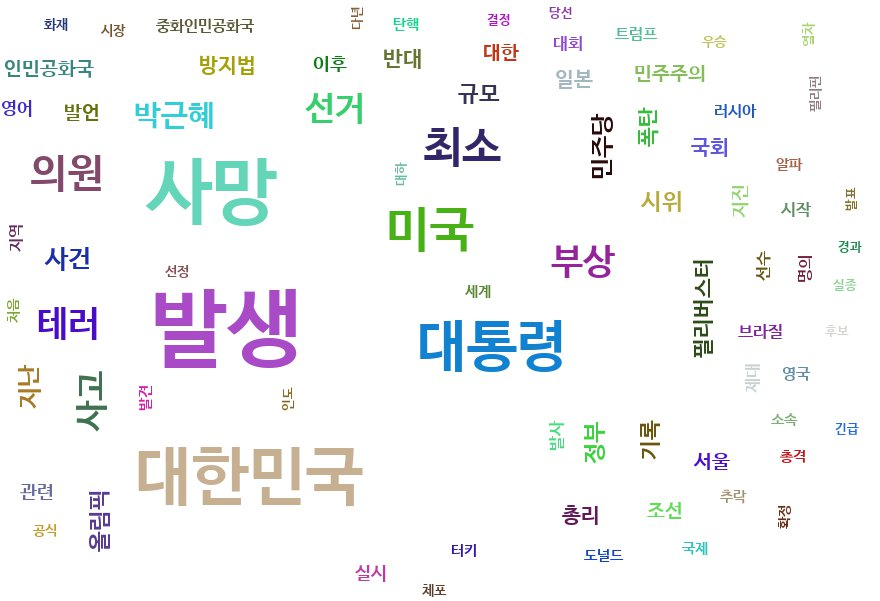

In [12]:
# 랜덤성을 줄이기 위해 random 시드 값 지정
random.seed(5)

# 딕셔너리 형태로 색깔과 단어의 크기, 단어가 저장된 리스트 반환.
taglist = pytagcloud.make_tags(cleaned_counter.most_common(80), maxsize=80)
pytagcloud.create_tag_image(taglist, 'wiki_wordcloud_example.jpg', size=(900, 600), fontname='NanumBarunGothicBold', rectangular=False)

Image(filename='wiki_wordcloud_example.jpg')

# 년별로 wordcloud 이미지 생성

In [13]:
# 앞서 사용한 코드 함수로 만든다.
def make_wordcloud(df):    
    df['내용'] = df['내용'].apply(lambda x: text_cleaning(x))
    content_corpus = "".join(df['내용'].to_list())
    
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(content_corpus)
    count = Counter(nouns)
    
    cleaned_counter = Counter({x: count[x] for x in count if len(x) > 1})
    cleaned_counter = Counter({x: cleaned_counter[x] for x in cleaned_counter if x not in stopwords})

    taglist = pytagcloud.make_tags(cleaned_counter.most_common(80), maxsize=70)
    
    return taglist

def wordcloud_img_save(name, taglist):
    file_name = f'wiki_{name}_wordcloud.jpg'
    wc_file_path = os.path.join(image_folder, file_name)
    
    # 이미지 파일이 존재하지 않을 때만 생성
    if not os.path.exists(wc_file_path):
        pytagcloud.create_tag_image(taglist, wc_file_path, size=(900, 600), fontname='NanumBarunGothicBold', rectangular=False)

In [14]:
# 현재 노트북 파일이 위치한 디렉토리 경로
current_dir = os.getcwd()

# 이미지를 저장할 폴더 경로
image_folder = os.path.join(current_dir, 'image')

# image 폴더가 없으면 생성
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

    for year in range(2016,2024):
        # 2016년 데이터에서 했던 방식 그대로 반복
        file_path = '년월별_요즘화제.xlsx'
        df = pd.read_excel(file_path, sheet_name = f'{year}년_월별_요즘화제')
    
        taglist = make_wordcloud(df)
        
        wordcloud_img_save(year, taglist)

# 평일, 공휴일, 2016년~2023년 word cloud 생성

## 전체 년도 데이터가 담긴 DataFrame 생성

In [15]:
file_path = '년월별_요즘화제.xlsx'
df = pd.read_excel(file_path, sheet_name = '2016년_월별_요즘화제')
for year in range(2017, 2024):    
    df_for_concat = pd.read_excel(file_path, sheet_name = f'{year}년_월별_요즘화제')
    df = pd.concat([df, df_for_concat], ignore_index=True)  

In [16]:
df.shape

(2238, 2)

## 날짜열 dtype 날짜 형식으로 수정

In [17]:
print(df['날짜'].head())
print(df['날짜'].tail())

0    2016년 1월 1일 (금요일)
1    2016년 1월 2일 (토요일)
2    2016년 1월 3일 (일요일)
3    2016년 1월 6일 (수요일)
4    2016년 1월 8일 (금요일)
Name: 날짜, dtype: object
2233    2023년 12월 18일 (2023-12-18) (월요일)
2234    2023년 12월 19일 (2023-12-19) (화요일)
2235    2023년 12월 21일 (2023-12-21) (목요일)
2236    2023년 12월 27일 (2023-12-27) (수요일)
2237    2023년 12월 29일 (2023-12-29) (금요일)
Name: 날짜, dtype: object


### 날짜 형식 통일

In [18]:
def cleaned_date(x):
    # 날짜 데이터에 괄호와 괄호 안의 내용 정규 표현식으로 찾기
    pattern = r'\([^)]*\)'
    # 괄호와 괄호 안의 내용을 삭제
    x = re.sub(pattern, '', x)
    
    return x.strip()

In [19]:
df['날짜'] = df['날짜'].apply(lambda x: cleaned_date(x))

In [20]:
print(df['날짜'].head())
print(df['날짜'].tail())

0    2016년 1월 1일
1    2016년 1월 2일
2    2016년 1월 3일
3    2016년 1월 6일
4    2016년 1월 8일
Name: 날짜, dtype: object
2233    2023년 12월 18일
2234    2023년 12월 19일
2235    2023년 12월 21일
2236    2023년 12월 27일
2237    2023년 12월 29일
Name: 날짜, dtype: object


### datetime으로 dtype 변경

In [21]:
df['날짜'] = pd.to_datetime(df['날짜'],format='%Y년 %m월 %d일')

In [22]:
df['날짜'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2238 entries, 0 to 2237
Series name: 날짜
Non-Null Count  Dtype         
--------------  -----         
2238 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.6 KB


## 공휴일인지 확인하는 열 추가

In [23]:
# 한국 공휴일 정보 로드
kr_holidays = holidays.KR()

def is_holiday(date):
    if date in kr_holidays:
        return 1
    else:
        return 0

In [24]:
df['공휴일여부'] = df['날짜'].apply(lambda x: is_holiday(x))

In [25]:
df.head()

,날짜,내용,공휴일여부
0,2016-01-01,대한민국의 국회의원 선거구가 이날 0시를 기해 무효가 되었다.,1
1,2016-01-02,사우디아라비아 정부가 시아파 지도자 님르 바크르 알님르를 비롯한 47명의 사형수를 ...,0
2,2016-01-03,사우디아라비아가 이란과의 국교를 단절하였다. 서해안고속도로에서 안개로 인해 17중 ...,0
3,2016-01-06,조선민주주의인민공화국이 수소폭탄 핵 실험을 전격 실시했다고 발표하였다.,0
4,2016-01-08,존엄사를 허용하는 웰다잉법이 국회를 통과했다. 주한미군이 포천시 영평사격장에서 아파...,0


## 각각 조건에 맞는 word cloud 이미지 저장

### 공휴일, 평일별 word cloud 생성

In [26]:
holi_taglist = make_wordcloud(df.loc[df['공휴일여부'] == 1].copy())
not_holi_taglist = make_wordcloud(df.loc[df['공휴일여부'] == 0].copy())

In [27]:
wordcloud_img_save('공휴일', holi_taglist)
wordcloud_img_save('평일', not_holi_taglist)

### 2016 ~ 2023년 전체 wordcloud 생성

In [28]:
total_taglist = make_wordcloud(df.copy())
wordcloud_img_save('2016_2023_전체', total_taglist)

# 각 뉴스의 개수 계산

In [29]:
file_path = '년월별_요즘화제.xlsx'

news_cnt = []
index = []
for year in range(2016, 2024):    
    df = pd.read_excel(file_path, sheet_name = f'{year}년_월별_요즘화제')
    index.append(year)
    news_cnt.append(df.shape[0])
news_cnt_series = pd.Series(news_cnt, index=index)
news_cnt_series

2016    271
2017    284
2018    333
2019    198
2020    365
2021    365
2022    296
2023    126
dtype: int64

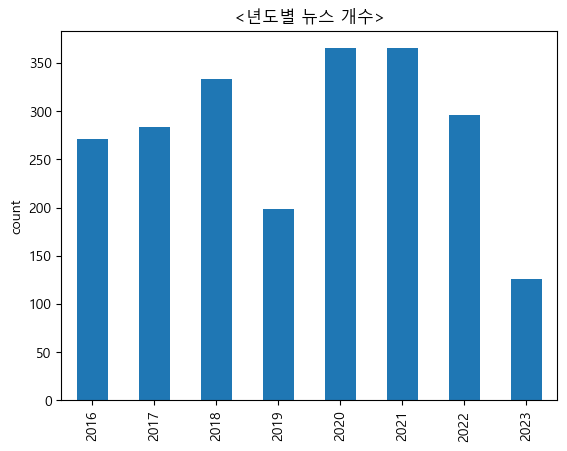

In [30]:
plt.rc('font', family='Malgun Gothic')
news_cnt_series.plot(kind='bar')
plt.title('<년도별 뉴스 개수>')
plt.ylabel('count')
plt.show()

# 한계점 파악
- 코로나 대유행시기에 다음과 같은 텍스트가 많이 발생했을 것이다.
- 다음과 같이 자연어를 처리하면 '진자'와 '수가'라는 단어가 많이 등장했을 것이다.

In [31]:
corpus = "2150명의 확진자가 발생하였다. 그 수가 어제보다 690명 증가했다."

cleaned_corpus = text_cleaning(corpus)
print(f"한글만 추출 : {cleaned_corpus}")

nouns_tagger = Okt()
nouns_of_corpus = nouns_tagger.nouns(cleaned_corpus)
count_of_corpus = Counter(nouns_of_corpus)
print(f"형태소 분석 결과 : {count_of_corpus}")

cleaned_counter_of_corpus = Counter({x: count_of_corpus[x] for x in count_of_corpus if len(x) > 1})
print(f"한 글자 제거 : {cleaned_counter_of_corpus}")

last_cleaned_counter = Counter({x: cleaned_counter_of_corpus[x] for x in cleaned_counter_of_corpus if x not in stopwords})
print(f"불용어 제거 : {last_cleaned_counter}")

한글만 추출 : 명의 확진자가 발생하였다 그 수가 어제보다 명 증가했다
형태소 분석 결과 : Counter({'명의': 1, '확': 1, '진자': 1, '발생': 1, '그': 1, '수가': 1, '어제': 1, '명': 1, '증가': 1})
한 글자 제거 : Counter({'명의': 1, '진자': 1, '발생': 1, '수가': 1, '어제': 1, '증가': 1})
불용어 제거 : Counter({'명의': 1, '진자': 1, '발생': 1, '수가': 1, '어제': 1, '증가': 1})


In [32]:
# 다음과 같이 수정해서 이미지를 저장할 수 있을 것이다.
last_cleaned_counter['확진자'] = last_cleaned_counter.pop('진자')
last_cleaned_counter.pop('수가')
last_cleaned_counter

Counter({'명의': 1, '발생': 1, '어제': 1, '증가': 1, '확진자': 1})

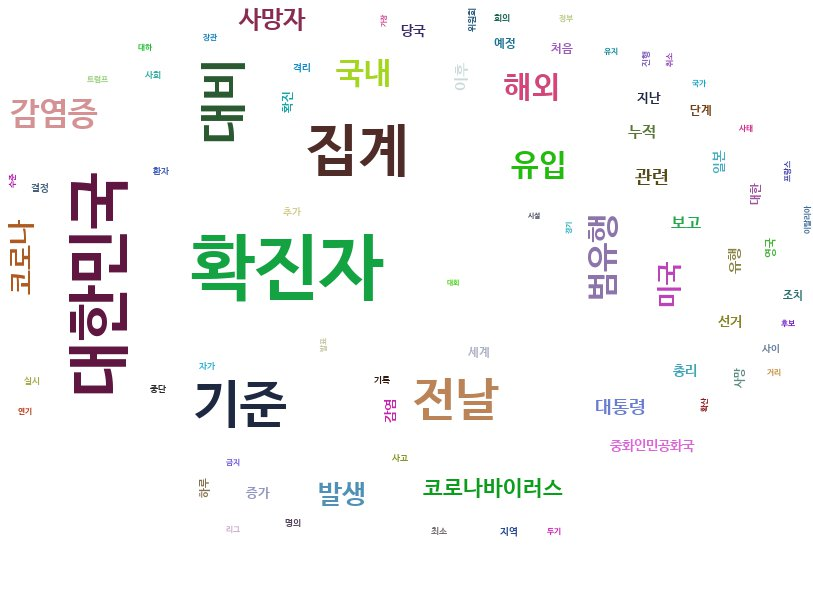

In [33]:
# 20년도만 이미지를 나타내본다.
file_path = '년월별_요즘화제.xlsx'
df = pd.read_excel(file_path, sheet_name = '2020년_월별_요즘화제')

df['내용'] = df['내용'].apply(lambda x: text_cleaning(x))
content_corpus = "".join(df['내용'].to_list())

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

cleaned_counter = Counter({x: count[x] for x in count if len(x) > 1})
cleaned_counter = Counter({x: cleaned_counter[x] for x in cleaned_counter if x not in stopwords})
cleaned_counter['확진자'] = cleaned_counter.pop('진자')
cleaned_counter.pop('수가')

taglist = pytagcloud.make_tags(cleaned_counter.most_common(80), maxsize=70)

pytagcloud.create_tag_image(taglist, 'image/wiki_wordcloud_2020_코로나_관련단어_수정.jpg', size=(900, 600), fontname='NanumBarunGothicBold', rectangular=False)
Image(filename='image/wiki_wordcloud_2020_코로나_관련단어_수정.jpg')